# Forecasting Consensus Expectations: Nonfarm Payrolls (NFP)

## Point and Directional Forecasts

**Imports**

In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from arch.univariate import ConstantMean, GARCH, StudentsT
from IPython.display import display, Markdown

In [36]:
OUT_DIR = "../out"         
DF_FILE       = "df.parquet"
DF_FULL_FILE  = "df_full.parquet"

df       = pd.read_parquet(os.path.join(OUT_DIR, DF_FILE),      engine="pyarrow")
df_full  = pd.read_parquet(os.path.join(OUT_DIR, DF_FULL_FILE), engine="pyarrow")

print("df shape     :", df.shape)
print("df_full shape:", df_full.shape)

df shape     : (73286, 10)
df_full shape: (84734, 10)


## 3.0: Baseline static forecast on full sample

Rolling 6-month fixed window. For every valid economist (for a prediction at time t, has a contiguous 6-month forecast history for previous 6 releases), weight prediction by inverse MSE. 


This implements an out-of-sample error estimate with a rolling 6-month estimation window. Weights don't use information from the target month and actual value at month *t* is unseen. In other words, all errors are "live" errors that could have been observed in real time.

Briefly, the procedure: 
1. Starts at 7th release (for 6 month release prior)
2. From estimation window, keep economists that supplied a forecast for all six months (per contiguity rule)
3. Compute MSE for each economist using errors against already known actuals (no lookahead)
4. Generate forecast for release t 
5. Store OOS evaluation error
6. Roll window forward a month and repeat

RMSE – smart : 666.70 k jobs
RMSE – median: 674.85 k jobs
DM statistic :  -0.91
p-value      : 0.3603


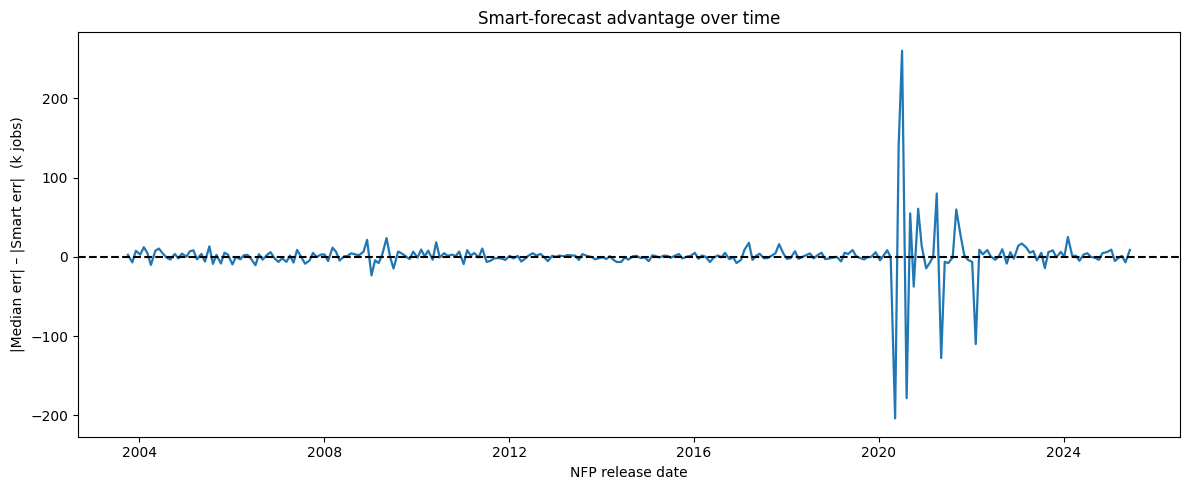


Latest unreleased forecast rows (actual is NaN):


,date,smart,median,actual
261,2025-07-03,111.754483,110.0,NaN


In [42]:
# ------------------------------------------------------------
# 1. Build smart & median forecasts for every release
#    (evaluation window = previous 6 releases)
# ------------------------------------------------------------
dates    = np.sort(df_full["release_date"].unique())
records  = []                         # collect all forecasts (even unreleased)

for idx in range(6, len(dates)):
    t_date  = dates[idx]              # target month
    window  = dates[idx-6:idx]        # six-month look-back

    # historical panel for weight estimation
    hist = df_full[df_full["release_date"].isin(window)]

    # economists with forecasts in every month of the window
    contig = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
    econs  = contig[contig].index
    if econs.empty:
        continue

    # inverse-MSE weights
    mse = (hist[hist["economist"].isin(econs)]
           .groupby("economist")["error"]
           .apply(lambda s: np.nanmean(np.square(s))))
    ridge   = 1e-6
    weights = 1.0 / (mse + ridge)
    weights /= weights.sum()

    # current-month forecasts, align & renormalise
    cur     = df_full[(df_full["release_date"] == t_date) &
                      (df_full["economist"].isin(econs))]
    f_t     = cur.set_index("economist")["forecast"].dropna()
    weights = weights.reindex(f_t.index).dropna()
    if weights.empty:
        continue
    weights /= weights.sum()

    # point forecasts
    smart   = np.dot(weights, f_t.loc[weights.index])
    median  = df_full.loc[df_full["release_date"] == t_date,
                          "forecast"].dropna().median()
    actual  = df_full.loc[df_full["release_date"] == t_date,
                          "actual"].iloc[0]          # may be NaN (e.g. July-25)

    records.append((t_date, smart, median, actual))

# ------------------------------------------------------------------
# 2. Split into “all” vs “evaluation” sets
# ------------------------------------------------------------------
oos_all  = pd.DataFrame(records,
                        columns=["date", "smart", "median", "actual"])
oos_eval = oos_all.dropna(subset=["actual"]).copy()     # evaluation sample

# ------------------------------------------------------------------
# 3. Evaluation metrics (only rows with realised actuals)
# ------------------------------------------------------------------
oos_eval["smart_err"]  = oos_eval["smart"]  - oos_eval["actual"]
oos_eval["median_err"] = oos_eval["median"] - oos_eval["actual"]

rmse_smart  = np.sqrt((oos_eval["smart_err"]**2).mean())
rmse_median = np.sqrt((oos_eval["median_err"]**2).mean())
print(f"RMSE – smart : {rmse_smart:6.2f} k jobs")
print(f"RMSE – median: {rmse_median:6.2f} k jobs")

# Diebold-Mariano test on squared-error loss
d        = oos_eval["smart_err"]**2 - oos_eval["median_err"]**2
dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
dm_p     = 2 * (1 - stats.norm.cdf(abs(dm_stat)))
print(f"DM statistic : {dm_stat:6.2f}")
print(f"p-value      : {dm_p:.4f}")

# ------------------------------------------------------------------
# 4. Visualise improvement timeline (evaluation sample)
# ------------------------------------------------------------------
oos_eval["improvement"] = (oos_eval["median_err"].abs() -
                           oos_eval["smart_err"].abs())

plt.figure(figsize=(12, 5))
plt.plot(oos_eval["date"], oos_eval["improvement"],
         lw=1.6, color="tab:blue")
plt.axhline(0, ls="--", c="k")
plt.title("Smart-forecast advantage over time")
plt.xlabel("NFP release date")
plt.ylabel("|Median err| – |Smart err|  (k jobs)")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 5. (Optional) Inspect the unreleased month’s forecasts
# ------------------------------------------------------------------
print("\nLatest unreleased forecast rows (actual is NaN):")
display(oos_all[oos_all["actual"].isna()])


Noticeably erratic performance in COVID and subsequent aftermath (~2020-2022). Pertinent to subset out as 2020-2022 is unlikely to be generalizable to future performance.

## 3.1: Static Forecast, inverse-MSE weighted

Here, in addition to the level forecast, we also introduce a directional forecast. Briefly: 


**Directional–forecast procedure (Beat / Miss classification)**  
1. For each release, keep valid economists within contiguity filter 
2. For every valid economist, compute trailing 6-month MSE, convert to weights (inverse MSE), build smart point forecast via normalized inverse-MSE weighting
3. Label the realized print (true y) as beat == 1 if y_t > median_t, miss == 1 otherwise. Same labeling procedure for smart forecast. 
4. Compute hit-rate: Fraction of releases where predicted sign matches realized sign. Test significance with a binomial/PT test. 
5. Do this for contiguity windows of 6, 12, and 24 months

In [53]:
# ─────────────────────────── settings ───────────────────────────
contiguity_windows = [3, 6, 12, 24]
methods            = ["inverse_mse", "inverse_mae", "equal_weight"]
ridge              = 1e-6

# helper ─────────────────────────────────────────────────────────
def run_static_panel(df_panel: pd.DataFrame, name: str):
    dates = np.sort(df_panel["release_date"].unique())
    eval_rows, live_rows = [], []

    for window, method in tqdm(product(contiguity_windows, methods),
                               total=len(contiguity_windows)*len(methods),
                               desc=f"{name} grid"):

        preds = []                     # per-release records
        for idx in range(window, len(dates)):
            t = dates[idx]
            # ----- look-back slice -----
            hist = df_panel[df_panel["release_date"].isin(dates[idx-window:idx])]
            # economists with all forecasts in window
            econs = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
            econs = econs[econs].index
            if econs.empty:  continue

            if method == "equal_weight":
                w = pd.Series(1.0, index=econs)
            else:
                grp = hist[hist["economist"].isin(econs)].groupby("economist")["error"]
                score = grp.apply(lambda s: np.nanmean(s**2) if method=="inverse_mse"
                                  else np.nanmean(np.abs(s)))
                w = 1.0/(score+ridge)
            w /= w.sum()

            # ----- current forecasts -----
            cur = df_panel[(df_panel["release_date"]==t) & (df_panel["economist"].isin(w.index))]
            f_t = cur.set_index("economist")["forecast"].dropna()
            w   = w.reindex(f_t.index).dropna()
            if w.empty:  continue
            w /= w.sum()

            smart  = np.dot(w, f_t.loc[w.index])
            median = df_panel.loc[df_panel["release_date"]==t, "forecast"].dropna().median()
            actual = df_panel.loc[df_panel["release_date"]==t, "actual"].iloc[0]
            preds.append((t, smart, median, actual))

        # nothing for this (window,method)?
        if not preds:  continue

        oos = pd.DataFrame(preds, columns=["date","smart","median","actual"])

        # save unreleased forecast (if latest actual is NaN)
        unreleased = oos[oos["actual"].isna()]
        if not unreleased.empty:
            last = unreleased.iloc[-1]
            live_rows.append({"panel" : name,
                              "window": window,
                              "method": method,
                              "date"  : last["date"],
                              "smart" : last["smart"],
                              "median": last["median"],
                              "pred_dir": int(last["smart"] > last["median"]) })

        # evaluation on realised months only
        eval_df = oos.dropna(subset=["actual"]).copy()
        if eval_df.empty:  continue

        eval_df["smart_err"]  = eval_df["smart"]  - eval_df["actual"]
        eval_df["median_err"] = eval_df["median"] - eval_df["actual"]
        eval_df["actual_dir"] = (eval_df["actual"] > eval_df["median"]).astype(int)
        eval_df["pred_dir"]   = (eval_df["smart"]  > eval_df["median"]).astype(int)

        obs         = len(eval_df)
        rmse_smart  = np.sqrt((eval_df["smart_err"]**2 ).mean())
        rmse_median = np.sqrt((eval_df["median_err"]**2).mean())

        d       = eval_df["smart_err"]**2 - eval_df["median_err"]**2
        dm_stat = d.mean()/d.std(ddof=1)*np.sqrt(obs)
        dm_p    = 2*(1-stats.norm.cdf(abs(dm_stat)))

        hits     = (eval_df["actual_dir"] == eval_df["pred_dir"]).astype(int)
        hit_rate = hits.mean()
        binom_p  = stats.binomtest(hits.sum(), obs, 0.5).pvalue
        p1,p2    = eval_df["pred_dir"].mean(), eval_df["actual_dir"].mean()
        c_joint  = (eval_df["pred_dir"] & eval_df["actual_dir"]).mean()
        pt_stat  = (c_joint-p1*p2)/np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
        pt_p     = 2*(1-stats.norm.cdf(abs(pt_stat)))

        eval_rows.append({"panel":name,"window":window,"method":method,
                          "obs":obs,"RMSE_smart":rmse_smart,"RMSE_median":rmse_median,
                          "HitRate":hit_rate,"Binom_p":binom_p,"PT_p":pt_p,"DM_p":dm_p})
    return pd.DataFrame(eval_rows), pd.DataFrame(live_rows)

# ─────────────────────────── run panels ─────────────────────────
res_covid, live_covid = run_static_panel(df,       "COVID")
res_full , live_full  = run_static_panel(df_full,  "Full")

# ───────────────── robust-winner pick (COVID panel) ────────────
robust = res_covid[(res_covid["DM_p"]<0.10)&
                   (res_covid["Binom_p"]<0.10)&
                   (res_covid["PT_p"]<0.10)]
winner = (robust if not robust.empty else res_covid).loc[
            lambda d: d["RMSE_smart"].idxmin() ]

win_w  = int(winner["window"]);  win_m = winner["method"]

# fetch its live forecast (COVID list suffices)
live_row = (live_covid[(live_covid["window"]==win_w)&
                       (live_covid["method"]==win_m)]
            if not live_covid.empty else pd.DataFrame())

# ────────────────────────── PRINT SECTION ──────────────────────
pd.set_option("display.float_format", "{:.3f}".format)

print("\n--- COVID-filtered panel (historical) ---")
print(res_covid.sort_values(["window","method"]).to_string(index=False))

print("\n--- Full panel (historical) ---")
print(res_full.sort_values(["window","method"]).to_string(index=False))

if not live_row.empty:
    lr = live_row.iloc[0]
    dir_txt = "Beat" if lr["pred_dir"]==1 else "Miss"
    print("\n--- LIVE FORECAST (robust winner) ---")
    print(f"Date     : {lr['date'].date()}")
    print(f"Smart    : {lr['smart']:.1f} k jobs")
    print(f"Median   : {lr['median']:.1f} k jobs")
    print(f"Direction: {dir_txt}  (method={win_m}, window={win_w} mo)")
else:
    print("\nNo unreleased month – all actuals available.")


COVID grid:   0%|          | 0/12 [00:00<?, ?it/s]

Full grid:   0%|          | 0/12 [00:00<?, ?it/s]


--- COVID-filtered panel (historical) ---
panel  window       method  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_p  DM_p
COVID       3 equal_weight  228      72.231       73.233    0.596    0.004 0.003 0.016
COVID       3  inverse_mae  228      72.184       73.233    0.570    0.040 0.032 0.040
COVID       3  inverse_mse  228      72.185       73.233    0.561    0.074 0.056 0.114
COVID       6 equal_weight  225      72.177       73.213    0.609    0.001 0.001 0.026
COVID       6  inverse_mae  225      72.150       73.213    0.573    0.033 0.025 0.028
COVID       6  inverse_mse  225      72.029       73.213    0.573    0.033 0.024 0.034
COVID      12 equal_weight  219      71.606       72.430    0.575    0.030 0.025 0.120
COVID      12  inverse_mae  219      71.548       72.430    0.562    0.079 0.063 0.099
COVID      12  inverse_mse  219      71.451       72.430    0.575    0.030 0.024 0.072
COVID      24 equal_weight  207      68.588       69.430    0.551    0.164 0.145 0.240


Clearly, level edge is eroded over the entire sample due to huge variance during COVID. 
- We need to subset out COVID period forecasts (or account for heavy tails somehow) if we want a good level forecast
- Directional edge can be maintained even through crises periods. Keep 6 or 12 month lookback window.

Inverse MSE weighting with a 12-month contiguity window provides best results 

**Stratified Analysis**

In [ ]:
# ---------------------------------------------------------------------------
# STRATIFIED STATIC ENSEMBLE – full panel (df_full)
# Handles missing actuals and produces live forecasts
# ---------------------------------------------------------------------------
windows = [3, 6, 12]        # contiguity windows to test
ridge   = 1e-6

# regime buckets (edit freely)
periods = {
    "2000-2007  (pre-GFC)"       : ("2000-01-01", "2007-12-31"),
    "2008-2009  (GFC crisis)"    : ("2008-01-01", "2009-12-31"),
    "2010-2019  (long expansion)": ("2010-01-01", "2019-12-31"),
    "2020-2022  (COVID + rebound)":("2020-01-01", "2022-12-31"),
    "2023-2025  (post-COVID)"    : ("2023-01-01", "2025-12-31")
}

dates_full = np.sort(df_full["release_date"].unique())
all_summaries = {}
live_preds    = []        # store unreleased-month forecasts

for W in windows:
    records = []

    # -------------------------------------------------------------
    # Walk forward through release dates
    # -------------------------------------------------------------
    for idx in tqdm(range(W, len(dates_full)),
                    desc=f"Static {W}-mo ensemble"):
        t_date      = dates_full[idx]
        window_back = dates_full[idx-W:idx]
        hist        = df_full[df_full["release_date"].isin(window_back)]

        # economists with full coverage in the window
        valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # inverse-MSE weights
        mse   = (hist[hist["economist"].isin(econs)]
                 .groupby("economist")["error"]
                 .apply(lambda s: np.nanmean(s**2)))
        w     = 1.0 / (mse + ridge)
        w    /= w.sum()

        # current forecasts & align
        cur   = df_full[(df_full["release_date"] == t_date) &
                        (df_full["economist"].isin(w.index))]
        f_t   = cur.set_index("economist")["forecast"].dropna()
        w     = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w    /= w.sum()

        yhat_smart  = np.dot(w, f_t.loc[w.index])
        yhat_median = df_full.loc[df_full["release_date"] == t_date,
                                  "forecast"].dropna().median()
        y_actual    = df_full.loc[df_full["release_date"] == t_date,
                                  "actual"].iloc[0]

        records.append((t_date, yhat_smart, yhat_median, y_actual))

    # ------------------------------------------------------------------
    # OOS DataFrame (keep NaN actual rows for live display)
    # ------------------------------------------------------------------
    cols     = ["date", "smart", "median", "actual"]
    oos_all  = pd.DataFrame(records, columns=cols)
    oos_eval = oos_all.dropna(subset=["actual"]).copy()

    # save live (unreleased) forecast, if any
    unreleased = oos_all[oos_all["actual"].isna()]
    if not unreleased.empty:
        live_preds.append({
            "window": W,
            "date":   unreleased.iloc[-1]["date"],
            "smart":  unreleased.iloc[-1]["smart"],
            "median": unreleased.iloc[-1]["median"]
        })

    # nothing to summarise yet?
    if oos_eval.empty:
        all_summaries[W] = pd.DataFrame()
        continue

    # error / direction columns
    oos_eval["smart_err"]  = oos_eval["smart"]  - oos_eval["actual"]
    oos_eval["median_err"] = oos_eval["median"] - oos_eval["actual"]
    oos_eval["actual_dir"] = (oos_eval["actual"] > oos_eval["median"]).astype(int)
    oos_eval["pred_dir"]   = (oos_eval["smart"]  > oos_eval["median"]).astype(int)

    # ------------------------------------------------------------------
    # Stratified summary table
    # ------------------------------------------------------------------
    summary = []
    for label, (start, end) in tqdm(periods.items(),
                                    desc=f"Stratified ({W}-mo)"):
        sub = oos_eval[(oos_eval["date"] >= start) & (oos_eval["date"] <= end)]
        if sub.empty:
            continue

        # DM statistic on squared errors
        d        = sub["smart_err"]**2 - sub["median_err"]**2
        dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
        dm_p     = 2*(1 - stats.norm.cdf(abs(dm_stat)))

        # directional metrics
        hits     = (sub["actual_dir"] == sub["pred_dir"]).astype(int)
        n        = len(hits)
        hit_rate = hits.mean()
        binom_p  = stats.binomtest(hits.sum(), n, 0.5).pvalue
        p1, p2   = sub["pred_dir"].mean(), sub["actual_dir"].mean()
        c_joint  = (sub["pred_dir"] & sub["actual_dir"]).mean()
        pt_stat  = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/n)
        pt_p     = 2*(1 - stats.norm.cdf(abs(pt_stat)))

        summary.append({
            "Period":   label,
            "Obs":      n,
            "HitRate":  hit_rate,
            "Binom_p":  binom_p,
            "PT_stat":  pt_stat,
            "PT_p":     pt_p,
            "DM_stat":  dm_stat,
            "DM_p":     dm_p
        })

    all_summaries[W] = pd.DataFrame(summary)

# ------------------------------------------------------------------
# Display stratified tables
# ------------------------------------------------------------------
for W, df_sum in all_summaries.items():
    print(f"\n=== Stratified Results for {W}-Month Window ===")
    if df_sum.empty:
        print("No realised data yet.")
    else:
        print(df_sum.to_string(index=False, float_format="{:.3f}".format))


Static 3-mo ensemble:   0%|          | 0/265 [00:00<?, ?it/s]

Stratified (3-mo):   0%|          | 0/5 [00:00<?, ?it/s]

Static 6-mo ensemble:   0%|          | 0/262 [00:00<?, ?it/s]

Stratified (6-mo):   0%|          | 0/5 [00:00<?, ?it/s]

Static 12-mo ensemble:   0%|          | 0/256 [00:00<?, ?it/s]

Stratified (12-mo):   0%|          | 0/5 [00:00<?, ?it/s]


=== Stratified Results for 3-Month Window ===
                      Period  Obs  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
        2000-2007  (pre-GFC)   54    0.593    0.220    1.226 0.220    0.188 0.851
     2008-2009  (GFC crisis)   24    0.625    0.307    1.448 0.148   -1.088 0.276
 2010-2019  (long expansion)  120    0.508    0.927    0.209 0.835   -0.015 0.988
2020-2022  (COVID + rebound)   36    0.611    0.243    0.943 0.346   -1.174 0.240
     2023-2025  (post-COVID)   30    0.667    0.099    0.848 0.397   -1.657 0.097

=== Stratified Results for 6-Month Window ===
                      Period  Obs  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
        2000-2007  (pre-GFC)   51    0.529    0.780    0.408 0.683    0.356 0.722
     2008-2009  (GFC crisis)   24    0.750    0.023    2.342 0.019   -1.095 0.274
 2010-2019  (long expansion)  120    0.533    0.523    0.777 0.437   -1.470 0.142
2020-2022  (COVID + rebound)   36    0.556    0.618    0.021 0.983   -0.899 0.369
    

1. Ex-COVID, 12-month inverse MSE ensemble beats median in magnitude of accuracy and directional edge. 
2. Crisis behavior (stress tests): level advantage disappears (variance of economist forecast explodes), ensemble has surprising directional edge in 08-09 crisis. Highly significant. 
3. Regime dependence: Skill of our model is clearest in the long, stable 2010-2019 period. Post-COVID shows no significance yet. Weights may need dynamic updating. 

Favor 12-month contiguity window. Future implementations we should augment with a crisis-robust variant (student t-likelihood to account for tails, dynamic weights).

# 3.2 Exponentially Weighted Moving Average (EWMA)

We'll now include (and tune) a decay hyperparameter.

In [41]:
windows = [3, 6, 12, 24]
decays  = np.arange(0.75, 1.00, 0.05)      # 0.75 … 0.95
ridge   = 1e-6

dates = np.sort(df["release_date"].unique())

results = []

for window, lam in tqdm(product(windows, decays),
                         total=len(windows)*len(decays),
                         desc="EWMA tuning"):
    records = []

    for idx in range(window, len(dates)):
        t_date      = dates[idx]
        window_dates = dates[idx-window:idx]          # ← ordinal look-back
        hist        = df[df["release_date"].isin(window_dates)]

        # economists with complete coverage
        valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # EWMA kernel (oldest → newest)
        ew = lam ** np.arange(window-1, -1, -1)
        ew = ew / ew.sum()

        # EWMA-MSE per economist
        scores = {}
        for econ in econs:
            errs = (hist.loc[hist["economist"] == econ]
                          .sort_values("release_date")["error"]
                          .values)
            assert len(errs) == window, "Window length mismatch"
            scores[econ] = np.sum(ew * errs**2)

        # inverse-MSE weights
        w = pd.Series({e: 1/(scores[e]+ridge) for e in econs})
        w /= w.sum()

        # align with current forecasts
        cur = df[(df["release_date"] == t_date) & (df["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.loc[w.index.intersection(f_t.index)]
        if w.empty:
            continue
        w /= w.sum()

        yhat_smart  = np.dot(w, f_t.loc[w.index])
        yhat_median = df.loc[df["release_date"] == t_date, "forecast"].dropna().median()
        y_actual    = df.loc[df["release_date"] == t_date, "actual"].iloc[0]
        records.append((t_date, yhat_smart, yhat_median, y_actual))

    # --- OOS evaluation ------------------------------------------------------
    oos = pd.DataFrame(records, columns=["date", "smart", "median", "actual"])
    if oos.empty:
        continue

    oos["smart_err"]   = oos["smart"]  - oos["actual"]
    oos["median_err"]  = oos["median"] - oos["actual"]
    oos["actual_dir"]  = (oos["actual"] > oos["median"]).astype(int)
    oos["pred_dir"]    = (oos["smart"]  > oos["median"]).astype(int)

    obs         = len(oos)
    rmse_smart  = np.sqrt((oos["smart_err"]**2).mean())
    rmse_median = np.sqrt((oos["median_err"]**2).mean())
    hit_rate    = (oos["actual_dir"] == oos["pred_dir"]).mean()

    d        = oos["smart_err"]**2 - oos["median_err"]**2
    dm_stat  = d.mean()/d.std(ddof=1)*np.sqrt(obs)
    dm_p     = 2*(1 - stats.norm.cdf(abs(dm_stat)))

    hits     = (oos["actual_dir"] == oos["pred_dir"]).astype(int)
    binom_p  = stats.binomtest(hits.sum(), obs, 0.5).pvalue
    p1, p2   = oos["pred_dir"].mean(), oos["actual_dir"].mean()
    c_joint  = (oos["pred_dir"] & oos["actual_dir"]).mean()
    pt_stat  = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
    pt_p     = 2*(1 - stats.norm.cdf(abs(pt_stat)))

    results.append({
        "window":      window,
        "decay":       lam,
        "obs":         obs,
        "RMSE_smart":  rmse_smart,
        "RMSE_median": rmse_median,
        "HitRate":     hit_rate,
        "Binom_p":     binom_p,
        "PT_stat":     pt_stat,
        "PT_p":        pt_p,
        "DM_stat":     dm_stat,
        "DM_p":        dm_p
    })

res_df = pd.DataFrame(results).sort_values(["window", "decay"])
print(res_df.to_string(index=False, float_format="{:.3f}".format))


EWMA tuning:   0%|          | 0/20 [00:00<?, ?it/s]

AssertionError: Window length mismatch

In [47]:
# ---------------------------------------------------------------------------
# EWMA-weighted inverse-MSE ensemble – COVID-filtered panel (df)
# Handles missing actuals and prints live forecasts
# ---------------------------------------------------------------------------
windows = [3, 6, 12, 24]
decays  = np.arange(0.75, 1.00, 0.05)    # 0.75 … 0.95
ridge   = 1e-6

dates = np.sort(df["release_date"].unique())
results     = []        # evaluation rows
live_preds  = []        # hold forecasts for unreleased month(s)

for window, lam in tqdm(product(windows, decays),
                        total=len(windows)*len(decays),
                        desc="EWMA tuning"):
    records = []

    for idx in range(window, len(dates)):
        t_date      = dates[idx]
        window_back = dates[idx-window:idx]
        hist        = df[df["release_date"].isin(window_back)]

        # economists with complete coverage in window
        valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
        econs = valid[valid].index
        if econs.empty:
            continue

        # EWMA kernel (oldest → newest)
        ew = lam ** np.arange(window-1, -1, -1)
        ew = ew / ew.sum()

        # EWMA-MSE per economist
        scores = {}
        for econ in econs:
            errs = (hist.loc[hist["economist"] == econ]
                          .sort_values("release_date")["error"]
                          .values)
            if len(errs) != window:          # rare edge-case guard
                continue
            scores[econ] = np.sum(ew * errs**2)

        if not scores:
            continue

        w = pd.Series({e: 1/(s + ridge) for e, s in scores.items()})
        w = w / w.sum()

        # align with current forecasts
        cur = df[(df["release_date"] == t_date) &
                 (df["economist"].isin(w.index))]
        f_t = cur.set_index("economist")["forecast"].dropna()
        w   = w.reindex(f_t.index).dropna()
        if w.empty:
            continue
        w = w / w.sum()

        yhat_smart  = np.dot(w, f_t.loc[w.index])
        yhat_median = df.loc[df["release_date"] == t_date,
                             "forecast"].dropna().median()
        y_actual    = df.loc[df["release_date"] == t_date,
                             "actual"].iloc[0]

        records.append((t_date, yhat_smart, yhat_median, y_actual))

    # ----------------- build OOS table ------------------------------------
    if not records:
        continue

    cols = ["date", "smart", "median", "actual"]
    oos  = pd.DataFrame(records, columns=cols)

    # save live forecast (unreleased) if present
    unreleased = oos[oos["actual"].isna()]
    if not unreleased.empty:
        live_preds.append({
            "window": window,
            "decay" : lam,
            "date"  : unreleased.iloc[-1]["date"],
            "smart" : unreleased.iloc[-1]["smart"],
            "median": unreleased.iloc[-1]["median"]
        })

    # evaluation subset – drop rows with NaN actual
    oos_eval = oos.dropna(subset=["actual"]).copy()
    if oos_eval.empty:
        # nothing to score yet – keep an empty row for bookkeeping
        results.append({
            "window":      window,
            "decay":       lam,
            "obs":         0,
            "RMSE_smart":  np.nan,
            "RMSE_median": np.nan,
            "HitRate":     np.nan,
            "Binom_p":     np.nan,
            "PT_stat":     np.nan,
            "PT_p":        np.nan,
            "DM_stat":     np.nan,
            "DM_p":        np.nan
        })
        continue

    # ----------------- metrics -------------------------------------------
    oos_eval["smart_err"]  = oos_eval["smart"]  - oos_eval["actual"]
    oos_eval["median_err"] = oos_eval["median"] - oos_eval["actual"]
    oos_eval["actual_dir"] = (oos_eval["actual"] > oos_eval["median"]).astype(int)
    oos_eval["pred_dir"]   = (oos_eval["smart"]  > oos_eval["median"]).astype(int)

    obs         = len(oos_eval)
    rmse_smart  = np.sqrt((oos_eval["smart_err"]**2).mean())
    rmse_median = np.sqrt((oos_eval["median_err"]**2).mean())
    hit_rate    = (oos_eval["actual_dir"] == oos_eval["pred_dir"]).mean()

    # Diebold-Mariano
    d       = oos_eval["smart_err"]**2 - oos_eval["median_err"]**2
    dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(obs)
    dm_p    = 2*(1 - stats.norm.cdf(abs(dm_stat)))

    # Binomial / PT
    hits    = (oos_eval["actual_dir"] == oos_eval["pred_dir"]).astype(int)
    binom_p = stats.binomtest(hits.sum(), obs, 0.5).pvalue
    p1, p2  = oos_eval["pred_dir"].mean(), oos_eval["actual_dir"].mean()
    c_joint = (oos_eval["pred_dir"] & oos_eval["actual_dir"]).mean()
    pt_stat = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/obs)
    pt_p    = 2*(1 - stats.norm.cdf(abs(pt_stat)))

    results.append({
        "window":      window,
        "decay":       lam,
        "obs":         obs,
        "RMSE_smart":  rmse_smart,
        "RMSE_median": rmse_median,
        "HitRate":     hit_rate,
        "Binom_p":     binom_p,
        "PT_stat":     pt_stat,
        "PT_p":        pt_p,
        "DM_stat":     dm_stat,
        "DM_p":        dm_p
    })

# --------------- summary tables ------------------------------------------
res_df = (pd.DataFrame(results)
          .sort_values(["window", "decay"])
          .reset_index(drop=True))
print(res_df.to_string(index=False, float_format="{:.3f}".format))

# --------------- live forecasts ------------------------------------------
if live_preds:
    live_df = pd.DataFrame(live_preds)
    print("\n=== Live EWMA smart & median forecasts for unreleased month(s) ===")
    print(live_df.to_string(index=False, float_format="{:.2f}".format))
else:
    print("\nAll months have realised actuals – no live EWMA forecast needed.")


EWMA tuning:   0%|          | 0/20 [00:00<?, ?it/s]

 window  decay  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
      3  0.750  228      72.121       73.233    0.566    0.055    2.011 0.044   -1.637 0.102
      3  0.800  228      72.136       73.233    0.575    0.029    2.286 0.022   -1.625 0.104
      3  0.850  228      72.149       73.233    0.579    0.020    2.424 0.015   -1.613 0.107
      3  0.900  228      72.162       73.233    0.570    0.040    2.168 0.030   -1.602 0.109
      3  0.950  228      72.174       73.233    0.566    0.055    2.052 0.040   -1.591 0.112
      6  0.750  225      72.015       73.213    0.582    0.016    2.534 0.011   -1.980 0.048
      6  0.800  225      72.020       73.213    0.578    0.023    2.394 0.017   -2.006 0.045
      6  0.850  225      72.024       73.213    0.578    0.023    2.405 0.016   -2.033 0.042
      6  0.900  225      72.027       73.213    0.578    0.023    2.405 0.016   -2.062 0.039
      6  0.950  225      72.028       73.213    0.578    0.023    2.40

- lambda = 0.95 decay on a 12-month lookback window seems best
- 24-month lookback window benefits from strong decay. 12-month is optimized with mild decay (.9-.95). Decay doesn't change 6-month window much as window is already short. 
- For this dataset, exponential decay does not seem to provide a clear benefit. It actually weakens RMSE and directional significance. 
- Error pattern may be fairly stationary in the 12 month window. Discounting doesn't reveal new information. 
- Might be a bias-vairance tradeoff issue (e.g. lowers bias but increases in variance of weight estimates renders bias improvement null)
- Decay likely isn't necessary for a 12-month window

**Commentary**
- Static inverse-MSE, 12-mo window (COVID filtered) provides an easy win
- EWMA decay adds no discernible value 
- Extreme shocks erode level accuracy, directional skill persists

## 3.3 Rolling-window soft-BMA with Student-t plug-in likelihood

In [ ]:
# Hyperparameter grid 
windows = [3, 6, 12, 24]            # contiguity windows to test
nu_grid = [3, 5, 10, 20, 50]     # Student-t degrees of freedom
ridge   = 1e-6                   # small regularizer to avoid div/0

results = []

# Grid search 
for window in tqdm(windows, desc="Window size"):
    for nu in tqdm(nu_grid, desc=f"Tuning ν (window={window}m)", leave=False):
        records = []

        # walk-forward through release dates
        for idx in range(window, len(dates)):
            t_date   = dates[idx]
            lookback = dates[idx-window:idx]
            hist     = df_full[df_full["release_date"].isin(lookback)]

            # require economists with full coverage
            valid = (
                hist.groupby("economist")["forecast"]
                    .apply(lambda s: s.notna().all())
            )
            econs = valid[valid].index
            if econs.empty:
                continue

            # compute each economist's log-likelihood under Student-t
            log_w = {}
            for econ in econs:
                errs = hist.loc[hist["economist"] == econ, "error"] \
                           .dropna().values
                if errs.size == 0:
                    continue
                sigma = np.std(errs, ddof=1)
                log_w[econ] = student_t.logpdf(errs, df=nu, loc=0, scale=sigma).sum()
            if not log_w:
                continue

            # softmax → posterior weights
            e_list = list(log_w.keys())
            lw_arr = np.array([log_w[e] for e in e_list])
            w_unn  = np.exp(lw_arr - lw_arr.max())
            w_ser  = pd.Series(w_unn, index=e_list)
            w_ser /= w_ser.sum()

            # align with current forecasts
            cur     = df_full[
                (df_full["release_date"] == t_date) &
                (df_full["economist"].isin(w_ser.index))
            ]
            f_t     = cur.set_index("economist")["forecast"].dropna()
            weights = w_ser.loc[w_ser.index.intersection(f_t.index)]
            if weights.empty:
                continue
            weights /= weights.sum()

            # smart & median forecasts
            yhat_smart  = (weights * f_t).sum()
            yhat_median = df_full.loc[
                              df_full["release_date"] == t_date, "forecast"
                          ].dropna().median()
            y_actual    = df_full.loc[
                              df_full["release_date"] == t_date, "actual"
                          ].iloc[0]

            records.append((t_date, yhat_smart, yhat_median, y_actual))

        # build out-of-sample table
        if not records:
            continue
        oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
        oos["smart_err"]  = oos["smart"]  - oos["actual"]
        oos["median_err"] = oos["median"] - oos["actual"]

        # Directional metrics
        oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)
        oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)
        hits              = (oos["actual_dir"] == oos["pred_dir"]).astype(int)
        hit_rate          = hits.mean()
        binom_p           = binomtest(hits.sum(), len(oos), 0.5).pvalue
        p1, p2            = oos["pred_dir"].mean(), oos["actual_dir"].mean()
        c_joint           = (oos["pred_dir"] & oos["actual_dir"]).mean()
        pt_stat           = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/len(oos))
        pt_p              = 2 * (1 - norm.cdf(abs(pt_stat)))

        # Level metrics
        rmse_smart  = np.sqrt((oos["smart_err"]**2).mean())
        rmse_median = np.sqrt((oos["median_err"]**2).mean())

        # Diebold–Mariano on squared errors
        d       = oos["smart_err"]**2 - oos["median_err"]**2
        dm_stat = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
        dm_p    = 2 * (1 - norm.cdf(abs(dm_stat)))

        # collect results
        results.append({
            "window":       window,
            "nu":           nu,
            "obs":          len(oos),
            "RMSE_smart":   rmse_smart,
            "RMSE_median":  rmse_median,
            "HitRate":      hit_rate,
            "Binom_p":      binom_p,
            "PT_stat":      pt_stat,
            "PT_p":         pt_p,
            "DM_stat":      dm_stat,
            "DM_p":         dm_p
        })

res_df = pd.DataFrame(results).sort_values("RMSE_smart")
print(res_df.to_string(index=False, float_format="{:.3f}".format))

Window size:   0%|          | 0/4 [00:00<?, ?it/s]

Tuning ν (window=3m):   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide b

Tuning ν (window=6m):   0%|          | 0/5 [00:00<?, ?it/s]

Tuning ν (window=12m):   0%|          | 0/5 [00:00<?, ?it/s]

Tuning ν (window=24m):   0%|          | 0/5 [00:00<?, ?it/s]

 window  nu  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
     24   5  207      68.678       69.430    0.546    0.211    1.319 0.187   -0.507 0.612
     24  10  207      68.681       69.430    0.551    0.164    1.458 0.145   -0.495 0.620
     24   3  207      68.683       69.430    0.556    0.126    1.597 0.110   -0.510 0.610
     24  20  207      68.695       69.430    0.551    0.164    1.459 0.145   -0.479 0.632
     24  50  207      68.713       69.430    0.556    0.126    1.598 0.110   -0.461 0.645
     12  50  219      70.781       72.430    0.571    0.042    2.114 0.035   -1.438 0.150
     12  20  219      70.805       72.430    0.575    0.030    2.252 0.024   -1.443 0.149
     12  10  219      70.842       72.430    0.571    0.042    2.119 0.034   -1.442 0.149
     12   5  219      70.900       72.430    0.575    0.030    2.252 0.024   -1.425 0.154
     12   3  219      70.955       72.430    0.571    0.042    2.114 0.035   -1.398 0.162
      6   

In [ ]:
# hyperparameter grid 
windows = [3, 6, 12, 24]            # contiguity windows to test
nu_grid = [3, 5, 10, 20, 50]     # Student-t degrees of freedom
ridge   = 1e-6                   # small regularizer to avoid div/0

results = []

# grid search 
for window in tqdm(windows, desc="Window size"):
    for nu in tqdm(nu_grid, desc=f"Tuning ν (window={window}m)", leave=False):
        records = []
        # walk-forward through release dates
        for idx in range(window, len(dates)):
            t_date   = dates[idx]
            lookback = dates[idx-window:idx]
            hist     = df[df["release_date"].isin(lookback)]

            # require economists with full coverage
            valid = (
                hist.groupby("economist")["forecast"]
                    .apply(lambda s: s.notna().all())
            )
            econs = valid[valid].index
            if len(econs) == 0:
                continue

            # compute each economist's log-likelihood under Student-t
            log_w = {}
            for econ in econs:
                errs = hist.loc[hist["economist"] == econ, "error"].dropna().values
                if errs.size == 0:
                    continue
                sigma = np.std(errs, ddof=1)
                log_w[econ] = student_t.logpdf(errs, df=nu, loc=0, scale=sigma).sum()
            if not log_w:
                continue

            # softmax → posterior weights
            e_list = list(log_w.keys())
            lw_arr = np.array([log_w[e] for e in e_list])
            w_unn  = np.exp(lw_arr - lw_arr.max())
            w_ser  = pd.Series(w_unn, index=e_list)
            w_ser /= w_ser.sum()

            # align with current forecasts
            cur     = df[
                (df["release_date"] == t_date) &
                (df["economist"].isin(w_ser.index))
            ]
            f_t     = cur.set_index("economist")["forecast"].dropna()
            weights = w_ser.loc[w_ser.index.intersection(f_t.index)]
            if weights.empty:
                continue
            weights /= weights.sum()

            # smart & median forecasts
            yhat_smart  = (weights * f_t).sum()
            yhat_median = df.loc[df["release_date"] == t_date, "forecast"] \
                              .dropna().median()
            y_actual    = df.loc[df["release_date"] == t_date, "actual"].iloc[0]

            records.append((t_date, yhat_smart, yhat_median, y_actual))

        # build out-of-sample table
        if not records:
            continue
        oos = pd.DataFrame(records, columns=["date","smart","median","actual"])
        oos["smart_err"]  = oos["smart"]  - oos["actual"]
        oos["median_err"] = oos["median"] - oos["actual"]

        # ── Directional metrics ───────────────────────────────────
        oos["actual_dir"] = (oos["actual"] > oos["median"]).astype(int)
        oos["pred_dir"]   = (oos["smart"]  > oos["median"]).astype(int)
        hits              = (oos["actual_dir"] == oos["pred_dir"]).astype(int)
        hit_rate          = hits.mean()
        binom_p           = binomtest(hits.sum(), len(oos), 0.5).pvalue
        p1, p2            = oos["pred_dir"].mean(), oos["actual_dir"].mean()
        c_joint           = (oos["pred_dir"] & oos["actual_dir"]).mean()
        pt_stat           = (c_joint - p1*p2) / np.sqrt(p1*p2*(1-p1)*(1-p2)/len(oos))
        pt_p              = 2 * (1 - norm.cdf(abs(pt_stat)))

        # Level metrics
        rmse_smart  = np.sqrt((oos["smart_err"]**2).mean())
        rmse_median = np.sqrt((oos["median_err"]**2).mean())

        # Diebold–Mariano on squared errors
        d        = oos["smart_err"]**2 - oos["median_err"]**2
        dm_stat  = d.mean() / d.std(ddof=1) * np.sqrt(len(d))
        dm_p     = 2 * (1 - norm.cdf(abs(dm_stat)))

        # collect
        results.append({
            "window":       window,
            "nu":           nu,
            "obs":          len(oos),
            "RMSE_smart":   rmse_smart,
            "RMSE_median":  rmse_median,
            "HitRate":      hit_rate,
            "Binom_p":      binom_p,
            "PT_stat":      pt_stat,
            "PT_p":         pt_p,
            "DM_stat":      dm_stat,
            "DM_p":         dm_p
        })

# report 
res_df = pd.DataFrame(results).sort_values("RMSE_smart")
print(res_df.to_string(index=False, float_format="{:.3f}".format))

Window size:   0%|          | 0/4 [00:00<?, ?it/s]

Tuning ν (window=3m):   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\Users\nwong\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2087: RuntimeWarning: divide b

Tuning ν (window=6m):   0%|          | 0/5 [00:00<?, ?it/s]

Tuning ν (window=12m):   0%|          | 0/5 [00:00<?, ?it/s]

Tuning ν (window=24m):   0%|          | 0/5 [00:00<?, ?it/s]

 window  nu  obs  RMSE_smart  RMSE_median  HitRate  Binom_p  PT_stat  PT_p  DM_stat  DM_p
     24   5  207      68.678       69.430    0.546    0.211    1.319 0.187   -0.507 0.612
     24  10  207      68.681       69.430    0.551    0.164    1.458 0.145   -0.495 0.620
     24   3  207      68.683       69.430    0.556    0.126    1.597 0.110   -0.510 0.610
     24  20  207      68.695       69.430    0.551    0.164    1.459 0.145   -0.479 0.632
     24  50  207      68.713       69.430    0.556    0.126    1.598 0.110   -0.461 0.645
     12  50  219      70.781       72.430    0.571    0.042    2.114 0.035   -1.438 0.150
     12  20  219      70.805       72.430    0.575    0.030    2.252 0.024   -1.443 0.149
     12  10  219      70.842       72.430    0.571    0.042    2.119 0.034   -1.442 0.149
     12   5  219      70.900       72.430    0.575    0.030    2.252 0.024   -1.425 0.154
     12   3  219      70.955       72.430    0.571    0.042    2.114 0.035   -1.398 0.162
      6   

**Observations**

Student-t, relative to inverse MSE modeling, downweights big misses. This drops the RMSE. However, day-to-day volatility of improvement also rises (weights fuctuate more). DM statistic is proportional to average drop in squared error and inversely proportional to s.d. of those drops. As such, we see an improvement in RMSE that is not statistically significant at 5% per the DM test. Inverse MSE delivers more consistent small-to-medium wins, while student-t wins bigger when there is an outlier. 

## 3.X Confidence Interval testing

**Median Forecast CIs**

Rolling expanding window (min. 36 releases), confidence intervals built around the median forecast

In [ ]:
# ───────────────────────── parameters ────────────────────────
MIN_TRAIN   = 36
LEVELS      = [0.50,0.60,0.70,0.80,0.90,0.95,0.99]
BETA_BASE   = 0
BETA_CRISIS = 0.80
PCTL_THRES  = 0.95            # crisis = top-5 % spread
PANELS      = {"COVID": df, "Full": df_full}

rows = []

for name, panel in PANELS.items():
    per_rel = (panel
        .groupby("release_date")
        .agg(median_fc=("median_forecast", "median"),
             actual    =("actual",          "first"),
             spread    =("forecast",        "std"))
        .reset_index()
        .sort_values("release_date"))
    per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]

    hits_static, hits_adj, totN = defaultdict(int), defaultdict(int), 0

    for i in tqdm(range(MIN_TRAIN, len(per_rel)),
                  desc=f"{name} rolling CI", leave=False):

        hist_err   = per_rel.loc[:i-1, "err"].values
        ν̂, μ̂, σ̂  = st.t.fit(hist_err)

        point  = per_rel.at[i, "median_fc"]
        actual = per_rel.at[i, "actual"]

        # spread stats (needed only for Full panel)
        if name == "Full":
            spread_t     = per_rel.at[i, "spread"]
            hist_spreads = per_rel.loc[:i-1, "spread"].values
            median_spread= np.median(hist_spreads)
            pct_rank     = (hist_spreads < spread_t).mean()
            β = BETA_BASE if pct_rank < PCTL_THRES else BETA_CRISIS
            spread_ratio = (spread_t / median_spread) - 1.0
            adj_factor   = 1.0 + β * spread_ratio

        for L in LEVELS:
            q   = st.t.ppf(1 - (1-L)/2, df=ν̂)
            h_s = q * σ̂                          # static half-width

            # ── static band (both panels) ──────────────────────────
            if (point+μ̂ - h_s) <= actual <= (point+μ̂ + h_s):
                hits_static[L] += 1

            # ── spread-adjusted band (Full panel only) ────────────
            if name == "Full":
                h_adj = adj_factor * h_s
                if (point+μ̂ - h_adj) <= actual <= (point+μ̂ + h_adj):
                    hits_adj[L] += 1

        totN += 1

    # store: COVID → only Static-t,  Full → Static-t and SpreadAdj-t
    for L in LEVELS:
        rows.append({"Panel": f"{name}-Static-t",
                     "Nominal": L,
                     "Empirical": hits_static[L]/totN})
        if name == "Full":
            rows.append({"Panel": f"{name}-SpreadAdj-t",
                         "Nominal": L,
                         "Empirical": hits_adj[L]/totN})

median_coverage_df = (
    pd.DataFrame(rows)
      .pivot(index="Panel", columns="Nominal", values="Empirical")
      .loc[["COVID-Static-t",
            "Full-Static-t","Full-SpreadAdj-t"]]  # display order
)

COVID rolling CI:   0%|          | 0/195 [00:00<?, ?it/s]

Full rolling CI:   0%|          | 0/231 [00:00<?, ?it/s]

In [ ]:
# Hyperparameters
MIN_TRAIN   = 36                                    # warm-up releases
LEVELS      = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
LAMBDAS     = [0.80, 0.85, 0.90, 0.95]              # test four decays

def ewma_quantile(values: np.ndarray, q: float, lam: float) -> float:
    """EWMA-weighted quantile of 'values' at probability q (0–1)."""
    n        = len(values)
    weights  = (1-lam) * lam**np.arange(n-1, -1, -1)   # oldest→newest
    sorter   = np.argsort(values)
    values   = values[sorter]
    weights  = weights[sorter]
    cdf      = np.cumsum(weights) / weights.sum()
    return np.interp(q, cdf, values)

# aggregate
per_rel = (
    df_full
    .groupby("release_date")
    .agg(median_fc=("median_forecast", "first"),
         actual    =("actual",           "first"))
    .reset_index()
    .sort_values("release_date")
)
per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]

rows = []

for lam in LAMBDAS:
    hits, totN = defaultdict(int), 0

    for i in tqdm(range(MIN_TRAIN, len(per_rel)),
                  desc=f"EWMA-γ (λ={lam:.2f})", leave=False):

        # expanding history
        errs   = per_rel.loc[:i-1, "err"].values
        ν̂, μ̂, σ̂ = st.t.fit(errs)

        abs_c  = np.abs(errs - μ̂)                    # centred |errors|
        point  = per_rel.at[i, "median_fc"]
        actual = per_rel.at[i, "actual"]

        for L in LEVELS:
            h_nom = st.t.ppf(1 - (1-L)/2, df=ν̂) * σ̂        # nominal
            h_emp = ewma_quantile(abs_c, L, lam)            # EWMA quantile
            γ     = h_emp / h_nom if h_nom > 0 else 1.0

            half  = γ * h_nom
            if (point + μ̂ - half) <= actual <= (point + μ̂ + half):
                hits[(lam, L)] += 1

        totN += 1

    # store λ-specific coverage
    for L in LEVELS:
        rows.append({"Lambda": lam,
                     "Nominal": L,
                     "Empirical": hits[(lam, L)] / totN})

ewma_calib_df = (
    pd.DataFrame(rows)
      .pivot(index="Lambda", columns="Nominal", values="Empirical")
      .sort_index()
)

EWMA-γ (λ=0.80):   0%|          | 0/231 [00:00<?, ?it/s]

EWMA-γ (λ=0.85):   0%|          | 0/231 [00:00<?, ?it/s]

EWMA-γ (λ=0.90):   0%|          | 0/231 [00:00<?, ?it/s]

EWMA-γ (λ=0.95):   0%|          | 0/231 [00:00<?, ?it/s]

In [ ]:
# Hyperparameter
MIN_TRAIN = 36                         # releases before first band
LEVELS    = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
SCALE     = 1000.0                     # rescale factor (k-jobs → 100s)

# ───────────────── aggregate median forecast errors ───────────
per_rel = (
    df_full
    .groupby("release_date")
    .agg(median_fc=("median_forecast", "first"),
         actual    =("actual",          "first"))
    .reset_index()
    .sort_values("release_date")
)
per_rel["err"] = per_rel["median_fc"] - per_rel["actual"]

# ─────────────────── expanding-window GARCH-t CIs ─────────────
hits, totN = defaultdict(int), 0

for i in tqdm(range(MIN_TRAIN, len(per_rel)), desc="Expanding GARCH-t CI"):
    
    # training residuals up to t-1 (rescaled)
    train_e = per_rel.loc[:i-1, "err"] / SCALE        # ① rescale
    
    cm = ConstantMean(train_e, rescale=False)         # silence warning
    cm.volatility  = GARCH(1, 1)
    cm.distribution = StudentsT()
    res = cm.fit(disp="off")
    
    # one-step forecast (still scaled)
    f = res.forecast(horizon=1)
    mu_hat_s   = f.mean.iloc[-1, 0]        # scaled bias (≈0)
    h_next_s   = f.variance.iloc[-1, 0]
    sigma_fc   = np.sqrt(h_next_s) * SCALE   # ② scale back
    mu_hat     = mu_hat_s * SCALE            # ③ scale bias back
    nu_hat     = res.params["nu"]
    
    point  = per_rel.at[i, "median_fc"]
    actual = per_rel.at[i, "actual"]
    
    for L in LEVELS:
        q       = st.t.ppf(1 - (1 - L)/2, df=nu_hat)
        half_w  = q * sigma_fc
        lower   = point + mu_hat - half_w
        upper   = point + mu_hat + half_w
        if lower <= actual <= upper:
            hits[L] += 1
    
    totN += 1

# ───────────────────── coverage summary ───────────────────────
garch_summary = pd.DataFrame({
    "nominal_level":      LEVELS,
    "empirical_coverage": [hits[L] / totN for L in LEVELS]
})


Expanding GARCH-t CI:   0%|          | 0/231 [00:00<?, ?it/s]

*Results*

In [ ]:
display(Markdown("### Median forecast confidence intervals (df vs df_full)"))
display(median_coverage_df.style.format("{:.3f}"))

display(Markdown("### Calibrated EWMA Student-t"))
display(ewma_calib_df.style.format("{:.3f}"))

display(Markdown("### Expanding-window GARCH-t coverage (scaled)"))
display(garch_summary.style.format("{:.3f}"))


### Median forecast confidence intervals (df vs df_full)

Nominal,0.500000,0.600000,0.700000,0.800000,0.900000,0.950000,0.990000
Panel,,,,,,,
COVID-Static-t,0.533,0.626,0.708,0.800,0.908,0.969,0.990
Full-Static-t,0.468,0.576,0.662,0.758,0.857,0.931,0.974
Full-SpreadAdj-t,0.519,0.636,0.719,0.801,0.905,0.965,0.996


### Calibrated EWMA Student-t

Nominal,0.500000,0.600000,0.700000,0.800000,0.900000,0.950000,0.990000
Lambda,,,,,,,
0.800000,0.502,0.571,0.645,0.740,0.844,0.900,0.939
0.850000,0.494,0.576,0.641,0.771,0.879,0.909,0.948
0.900000,0.502,0.567,0.645,0.779,0.892,0.918,0.961
0.950000,0.494,0.576,0.671,0.775,0.883,0.935,0.961


### Expanding-window GARCH-t coverage (scaled)

,nominal_level,empirical_coverage
0,0.500,0.506
1,0.600,0.602
2,0.700,0.701
3,0.800,0.762
4,0.900,0.870
5,0.950,0.931
6,0.990,0.974


**Confidence intervals built around smart NFP forecast**

In [ ]:
# import numpy as np, pandas as pd, scipy.stats as st
# from collections import defaultdict
# from tqdm.auto import tqdm

# # ───────────────────────── parameters ───────────────────────
# LOOKBACKS  = [3, 6, 12]                  # inverse-MSE windows (mo)
# LEVELS     = [0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
# RIDGE      = 1e-6
# MIN_TRAIN  = 36

# PANELS = {                      # name → DataFrame
#     "Full":  df_full,
#     "COVID-filtered": df
# }

# # container for coverage rows
# rows = []

# # ───────────────────────── main loop ─────────────────────────
# for panel_name, panel in PANELS.items():
#     dates = np.sort(panel["release_date"].unique())

#     for LB in LOOKBACKS:
#         # 1) smart forecast + errors
#         recs = []
#         for idx in range(LB, len(dates)):
#             t = dates[idx]
#             hist = panel[panel["release_date"].isin(dates[idx-LB:idx])]

#             # economists with full coverage in window
#             valid = hist.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
#             econs = valid[valid].index
#             if econs.empty:   continue

#             mse = (hist[hist["economist"].isin(econs)]
#                    .groupby("economist")["error"]
#                    .apply(lambda s: np.nanmean(s**2)))
#             w = 1/(mse + RIDGE);  w /= w.sum()

#             cur = panel[(panel["release_date"] == t) & (panel["economist"].isin(w.index))]
#             f_t = cur.set_index("economist")["forecast"].dropna()
#             w   = w.loc[w.index.intersection(f_t.index)]
#             if w.empty:   continue
#             w /= w.sum()

#             smart = np.dot(w, f_t.loc[w.index])
#             actual = panel.loc[panel["release_date"] == t, "actual"].iloc[0]
#             recs.append((smart, actual))

#         oos = pd.DataFrame(recs, columns=["smart", "actual"])
#         oos["err"] = oos["smart"] - oos["actual"]

#         # 2) expanding-window CIs
#         hits, totN = defaultdict(int), 0
#         for i in tqdm(range(MIN_TRAIN, len(oos)),
#                       desc=f"{panel_name} {LB}-mo", leave=False):
#             nu, mu, sig = st.t.fit(oos.iloc[:i]["err"].values)
#             point, actual = oos.iloc[i][["smart", "actual"]]

#             for L in LEVELS:
#                 q   = st.t.ppf(1-(1-L)/2, df=nu)
#                 hw  = q*sig
#                 if (point+mu-hw) <= actual <= (point+mu+hw):
#                     hits[L] += 1
#             totN += 1

#         # 3) store coverage
#         for L in LEVELS:
#             rows.append({
#                 "Panel": panel_name,
#                 "Lookback": LB,
#                 "Nominal": L,
#                 "Empirical": hits[L]/totN
#             })

# # ───────────────────────── display nicely ────────────────────
# coverage_df = (pd.DataFrame(rows)
#                .pivot_table(index=["Panel","Lookback"],
#                             columns="Nominal",
#                             values="Empirical")
#                .sort_index())
# coverage_df.style.format("{:.3f}")
